# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1sWhxFwr9XOqVmmyxqW2Y33HJrW31QtPb?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install -U torch==1.13.1+cu116 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 531.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1+cu121
    Uninstalling torch-2.3.1+cu121:
      Successfully uninstalled torch-2.3.1+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 1.13.1+cu116 which is incompatible.
torchvision 0.18.1+cu121 requires torch==2.3.1, but you have torch 1.13.1+cu116 which is incompatible.


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
spam = False
not_spam = False
for line in open('SMSSpamCollection'):
    # splitting label from text
    label,text = line.split('\t')
    if(label == 'ham' and not_spam == False):
      print(line)
      not_spam = True
    if(label == 'spam' and spam == False):
      print(line)
      spam = True

print("Referencing the documentation provided, the label for spam is spam and the label for non-spam is ham")

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Referencing the documentation provided, the label for spam is spam and the label for non-spam is ham


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [4]:
spam = []
not_spam = []
for line in open('SMSSpamCollection'):
    # splitting label from text
    label,text = line.split('\t')
    if(label == 'ham'):
      not_spam.append(text)
    if(label == 'spam'):
      spam.append(text)

print("Number of spam messages: " + str(len(spam)))

print("Number of non-spam messages: "+ str(len(not_spam)))

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

*Referenced https://medium.com/@tam.tamanna18/power-of-character-level-rnns-and-embeddings-in-natural-language-processing-b84321d199ad for this explanation

--> Some advantages of using a character level RNN is that they can handle out-of-vocabulary words very well, meaning the model can still process new/novel words it has never encountered before in text. This is useful for modelling SMS texts since they often most likely contain modified words like slang or abbreviations etc. Additionally, character level RNN's are generally very robust to noise in text data, which again is useful for SMS texts since they contain alot of mispelled words, abbreviations etc.

--> Some disadvantages of using a character level RNN is that since they do not process the words in a sentence/text collectivelly, the meaning of the text can be lost; which could have been useful in differentiating a spam text from a non-spam text. Additionally, modelling SMS texts as characters would mean more tokens to process, leading to more computational complexity/processing times.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [5]:
# importing neccessary classes
import torchtext
from torchtext import data
from torchtext.data import TabularDataset, Field

In [6]:
# defining preprocessing to convert labels from strings to numerical values
def preprocess_label(label):
  if (label == 'ham'):
    label = 0
  else: label = 1
  return label

# define a character-level tokenizer
def tokenizer(text):
  return list(text)

# defining fields
label_field = Field(sequential = False,use_vocab = False, is_target = True,
                    dtype = torch.int64, preprocessing = preprocess_label,
                    batch_first = True)
text_field = Field(sequential = True, tokenize = tokenizer,include_lengths = True,
                   batch_first = True)

fields = [('label', label_field), ('text', text_field)]

loaded_data = data.TabularDataset(
path= "/content/SMSSpamCollection", format='tsv',
fields= fields)


In [7]:
# splitting dataset into train,validation and test dataset
# want to make sure stratified random sampling is occuring
random_seed = np.random.seed(50)
train,val,test = loaded_data.split(split_ratio = [0.6,0.2,0.2],
                                   stratified = True, random_state =random_seed )

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [8]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [9]:
#print("Number of training examples is:", len(train))

--> Having a balanced training set is benifical so that our neural network actually learns to differentiate/seperate between the 2 classess of labels, spam and ham. If the training set heavily consisted of only ham data, then our model is likely to learn to classify everything as ham, since it would correctly classify most of the training data by doing so.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [10]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7e8d6e7b3b20>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'C': 33, 'I': 34, 'S': 35, 'O': 36, '4': 37, '7': 38, 'N': 39, 'x': 40, '6': 41, 'A': 42, '3': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'W': 48, 'P': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, 'G': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '&': 63, ':': 64, '-': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, 'q': 76, '(': 77, 'Q': 78, '"': 79, '#': 80, '@': 81, '>': 82, 'Z': 83, '=': 84, 'ü': 85, 'Ü': 86, '‘': 87, '$': 88, '\x92': 89, '<': 90, '%': 91, '_': 92, '\x93': 93, '¡': 94, '“': 95, '|': 96, '…': 97, '\x94': 

--> text_field.vocab.stoi returns a dictionary containing every possible character token in the training data as keys and their corresponding numerical indices as values

--> text_field.vocab.itos returns a list of every character token, indexed by their numerical indices

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

--> < unk > represents an unknown/out-of-vocabulary token

--> < pad > represents a special token that is used to make batches of tokens
            the same size

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [11]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [12]:
batch_num = 1
for batch in train_iter:
    print("Batch Number: " + str(batch_num))
    print(batch.text)
    print(batch.label)
    print("maximum input sequence length: " + str(batch.text[0].shape[1]))
    print("number of pad tokens used: " + str(batch.text[0].eq(1).sum().item()))
    print()
    batch_num += 1
    if (batch_num == 10):
      break


Batch Number: 1
(tensor([[50, 44, 57,  ..., 32, 78, 50],
        [48, 13,  6,  ...,  8,  3, 45],
        [48, 13,  6,  ...,  8,  3, 45],
        ...,
        [54,  3,  6,  ..., 21, 18,  1],
        [50, 44, 57,  ..., 21, 18,  1],
        [50, 44, 57,  ..., 21, 18,  1]]), tensor([154, 154, 154, 154, 154, 154, 153, 153, 153, 153, 153, 153, 153, 153,
        153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
        153, 153, 153, 153]))
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
maximum input sequence length: 154
number of pad tokens used: 26

Batch Number: 2
(tensor([[35,  4,  8,  ...,  7, 24,  4],
        [58,  8,  3,  ..., 17,  3, 16],
        [42, 10,  2,  ..., 42, 21,  8],
        ...,
        [39,  4,  2,  ..., 24,  4,  1],
        [58,  8,  3,  ..., 17, 30,  1],
        [49, 11,  3,  ...,  3, 45,  1]]), tensor([148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
        148, 

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [13]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [14]:
# initializing a simple GRU model
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    self.name = "Spam_Rnn"
    super(RNN,self).__init__()
    self.emb = torch.eye(len(text_field.vocab.stoi))
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size,hidden_size, batch_first = True )
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    x = self.emb[x] # converting batch of characters into one-hot encodings
    h0 = torch.zeros(1,x.size(0),self.hidden_size)
    out,_ = self.rnn(x,h0)
    return self.fc(torch.max(out, dim=1)[0])

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [26]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    total = 0
    for batch in data:
      text = batch.text[0]
      labels = batch.label
      output = model(text)
      # select maximum prediction
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
      total += text.shape[0]
    return correct/total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [27]:
def evaluate(model, loader, criterion):
    total_loss = 0.0
    total_epoch = 0
    i = 0
    for batch in loader:
        text = batch.text[0]
        labels = batch.label
        pred = model(text)
        loss = criterion(pred,labels)
        total_loss += loss.item()
        i += 1
    loss = float(total_loss) / (i + 1)
    return loss

In [28]:
def get_model_name(name, batch_size, learning_rate, epoch,size_hidden):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_sizeofhiddenstates{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,size_hidden)
    return path

In [35]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of iterations
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_err[-1]))
    print("Final Validation Accuracy: {}".format(val_err[-1]))

In [34]:
# getting length of train and validation data set
#print("Number of training examples is:", len(train))
#print("Number of validation examples is:", len(val))

In [31]:
def train_model(model,num_epochs=5, learning_rate=1e-4, batchsize = 64,
                size_hidden = 100):
########################################################################
# loading in data
  train_iter = torchtext.data.BucketIterator(train,
                                          batch_size= 64,
                                          sort_key=lambda x: len(x.text),
                                          sort_within_batch=True,
                                          repeat=False)
  val_iter = torchtext.data.BucketIterator(val,
                                          batch_size=64,
                                          sort_key=lambda x: len(x.text),
                                          sort_within_batch=True,
                                          repeat=False)
########################################################################
    # Storing train/validation accuracy and loss
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
########################################################################
  """ Training loop"""
  torch.manual_seed(42)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  iterations = 0
  for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_epoch = 0
      i = 0
      #print("test")
      for batch in train_iter:
          text = batch.text[0]
          labels = batch.label
          optimizer.zero_grad()
          pred = model(text)
          loss = criterion(pred,labels)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()
          i += 1

  # calculate and save train loss and accuracy every epoch
      train_loss[epoch] = (float(total_train_loss)/(i+1))
      val_loss[epoch] = evaluate(model, val_iter, criterion)
      train_acc[epoch] = (get_accuracy(model, train_iter))
      val_acc[epoch] = (get_accuracy(model,val_iter))

  # Save current model to file
      epoch += 1
      model_path = get_model_name(model.name, batchsize, learning_rate, epoch,
                                  size_hidden)
      torch.save(model.state_dict(), model_path)

  # Write the train/test loss/err into CSV file for plotting later
  iterations = np.arange(1, iterations + 1)
  np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [32]:
# getting input size
input_size = len(text_field.vocab.stoi)

# rnn wil have hidden_size = 100 and binary classes
rnn = RNN(input_size,100,2)

train_model(rnn, num_epochs = 20, learning_rate = 0.001, batchsize = 64,
            size_hidden = 100)

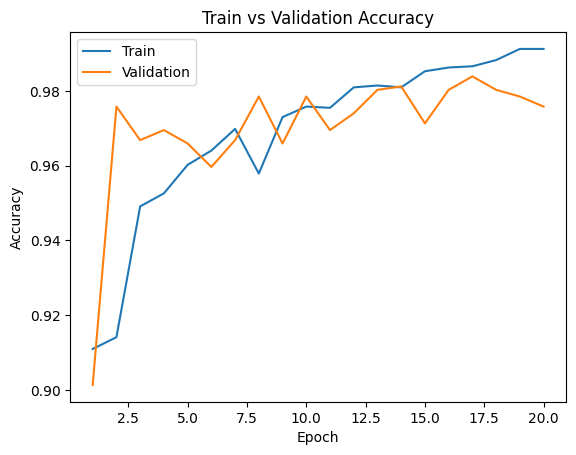

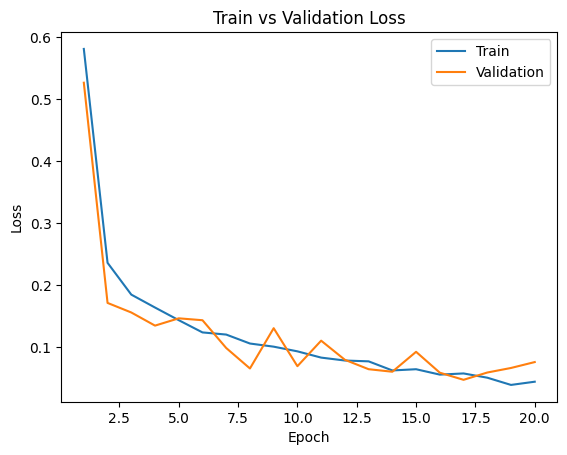

Final Training Accuracy: 0.9912120709666722
Final Validation Accuracy: 0.9757847533632287


In [36]:
plot_training_curve(get_model_name(name = 'Spam_Rnn', batch_size = 64,
                          learning_rate = 0.001, epoch= 20, size_hidden = 100))

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [38]:
# Model 1

# Hyperparameters
# learning rate = 0.001
# number of epochs = 30
# dimension of hidden state = 150
# RNN output = max and mean pooling

## ** changes made **

## number of epochs was increased from 20 to 30, to allow model more iterations
## to learn from training data since it seemed to be underfitting

## dimension of hidden state was increased to 150, to see if it will increase
## the accuracy of the rnn

## RNN output was changed from max-pooling to a concatanated version of max
## and mean pooling to increase model accuracy

In [52]:
# initializing an updated GRU model
class RNN_V2(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    self.name = "Spam_Rnn_V2"
    super(RNN_V2,self).__init__()
    self.emb = torch.eye(len(text_field.vocab.stoi))
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size,hidden_size, batch_first = True )
    self.fc = nn.Linear( 2* hidden_size, num_classes)

  def forward(self,x):
    x = self.emb[x] # converting batch of characters into one-hot encodings
    h0 = torch.zeros(1,x.size(0),self.hidden_size)
    out,_ = self.rnn(x,h0)
    out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
    return self.fc(out)

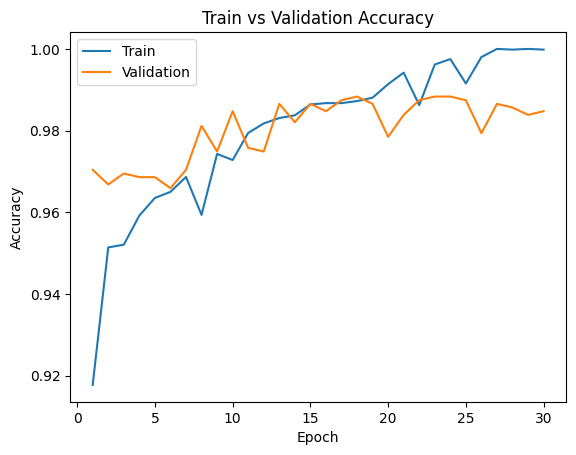

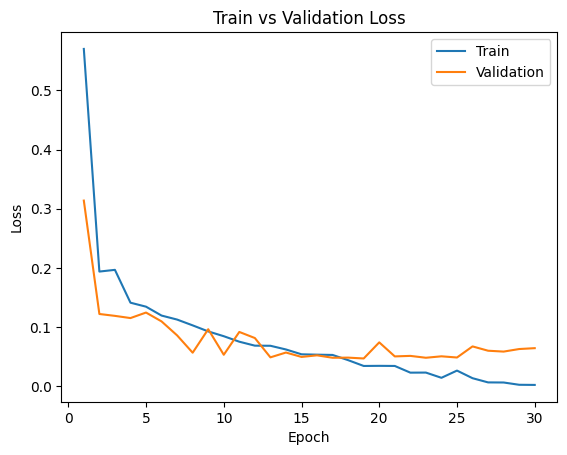

Final Training Accuracy: 0.9998341900182391
Final Validation Accuracy: 0.9847533632286996


In [53]:
rnn_2 = RNN_V2(input_size,hidden_size = 150, num_classes = 2)

train_model(rnn_2, num_epochs = 30, learning_rate = 0.001, batchsize = 64,
            size_hidden = 150)

plot_training_curve(get_model_name(name = 'Spam_Rnn_V2', batch_size = 64,
                          learning_rate = 0.001, epoch= 30, size_hidden = 150))

In [58]:
# Model 2

# Hyperparameters
# learning rate = 0.00085
# number of epochs = 40
# dimension of hidden state = 200
# RNN output = max and mean pooling

## ** changes made **

## dimension of hidden state was increased from 150 to 200, because the
## validation accuracy increased when the dimension of hidden state was increased
## in the previous model

## number of epochs was increased from 30 to 40, to allow model more iterations
## to train, and hopefully increase model accuracy

## to prevent overfitting, learning rate was slightly decreased from 0.001 to
## 0.00085

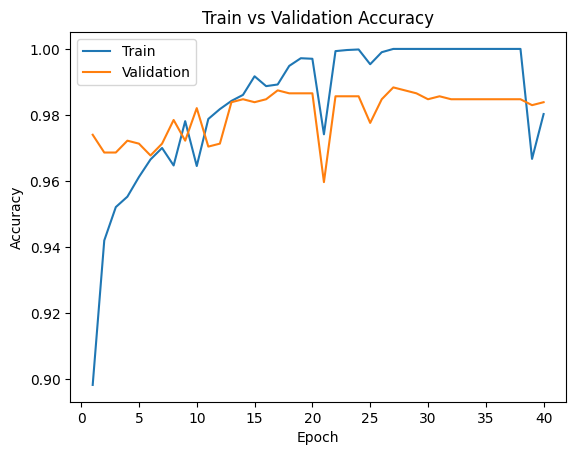

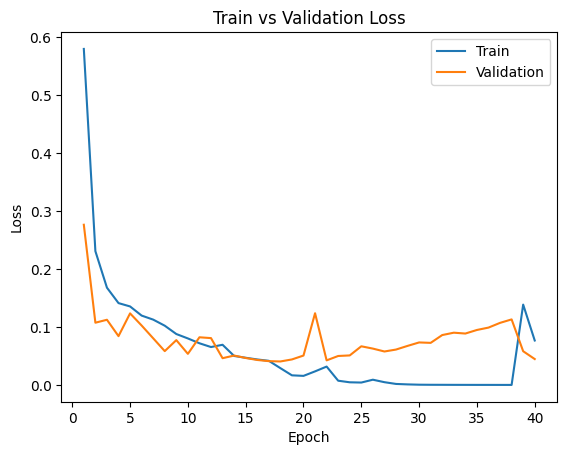

Final Training Accuracy: 0.9802686121704527
Final Validation Accuracy: 0.9838565022421525


In [57]:
rnn_2 = RNN_V2(input_size,hidden_size = 200, num_classes = 2)

train_model(rnn_2, num_epochs = 40, learning_rate = 0.00085, batchsize = 64,
            size_hidden = 200)

plot_training_curve(get_model_name(name = 'Spam_Rnn_V2', batch_size = 64,
                          learning_rate = 0.00085, epoch= 40, size_hidden = 200))

In [63]:
# Model 3

# Hyperparameters
# learning rate = 0.0006
# number of epochs = 40
# dimension of hidden state = 200
# RNN output = max and mean pooling

## ** changes made **

## the model overfitted in the previous model, therefore the learning rate
## will be slightly decreased from 0.00085 to 0.0006

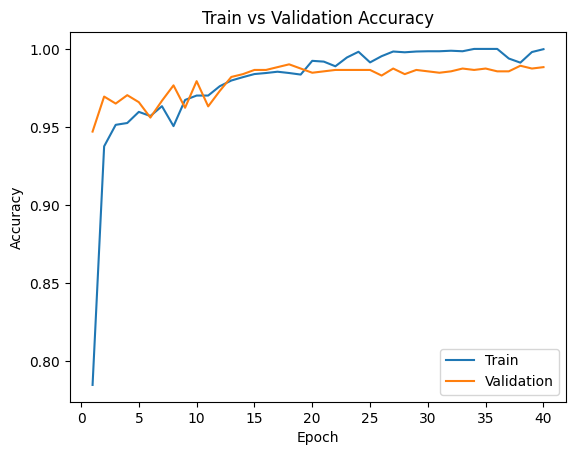

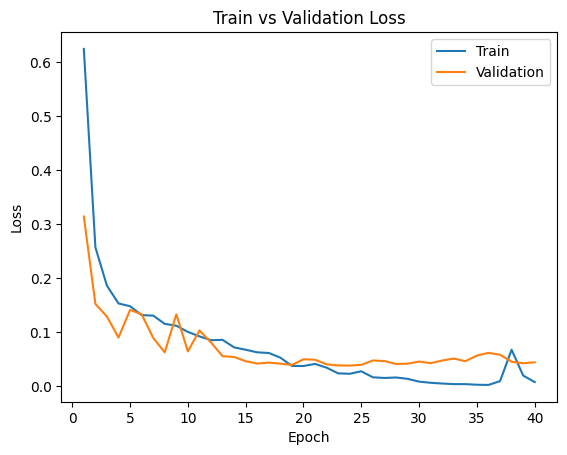

Final Training Accuracy: 0.9998341900182391
Final Validation Accuracy: 0.9883408071748879


In [62]:
rnn_2 = RNN_V2(input_size,hidden_size = 200, num_classes = 2)

train_model(rnn_2, num_epochs = 40, learning_rate = 0.0006, batchsize = 64,
            size_hidden = 200)

plot_training_curve(get_model_name(name = 'Spam_Rnn_V2', batch_size = 64,
                          learning_rate = 0.0006, epoch= 40, size_hidden = 200))

--> The best model was model 3 with a final validation accuracy of ~98.83%

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [74]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

# creating a data iterable for spam examples
val_iter_spam = torchtext.data.BucketIterator(valid_spam,
                                        batch_size=64,
                                        sort_key=lambda x: len(x.text),
                                        sort_within_batch=True,
                                        repeat=False)

# creating a data iterable for ham examples
val_iter_ham = torchtext.data.BucketIterator(valid_nospam,
                                        batch_size=64,
                                        sort_key=lambda x: len(x.text),
                                        sort_within_batch=True,
                                        repeat=False)

In [75]:
# loading in final model
spam_rnn = RNN_V2(input_size,hidden_size = 200, num_classes = 2)
model_path = get_model_name(spam_rnn.name, batch_size=64, learning_rate=0.0006,
                            epoch=40,size_hidden = 200)
state = torch.load(model_path)
spam_rnn.load_state_dict(state)

<All keys matched successfully>

In [83]:
# getting false positive rate
test_accuracy = get_accuracy(spam_rnn, val_iter_ham)
print("False Postive rate :", (1-test_accuracy)*100, "%")

False Postive rate : 0.4145077720207224 %


In [85]:
# getting false negative rate
test_accuracy = get_accuracy(spam_rnn, val_iter_spam)
print("False Negative rate :", (1-test_accuracy)*100, "%")

False Negative rate : 7.9999999999999964 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

--> A False Negative would mean that a spam message was marked as ham, and thus the spam message would have bypassed the spam detection algorithm. This would have a severe impact since spam messages can be malicious.

--> A False Positive would mean that a ham message was marked as spam, and thus the ham message would have been blocked by the spam detection algorithm. This usually would have a benign impact since an actual message being blocked usually is not significant/impactful.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [87]:
# getting test accuracy
test_iter = torchtext.data.BucketIterator(test,
                                        batch_size=64,
                                        sort_key=lambda x: len(x.text),
                                        sort_within_batch=True,
                                        repeat=False)
test_accuracy = get_accuracy(spam_rnn, test_iter)
print("Test Accuracy :", (test_accuracy)*100, "%")

Test Accuracy : 98.65350089766606 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [88]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    val.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    val.fields)

# creating a data iterable for spam examples
test_iter_spam = torchtext.data.BucketIterator(valid_spam,
                                        batch_size=64,
                                        sort_key=lambda x: len(x.text),
                                        sort_within_batch=True,
                                        repeat=False)

# creating a data iterable for ham examples
test_iter_ham = torchtext.data.BucketIterator(valid_nospam,
                                        batch_size=64,
                                        sort_key=lambda x: len(x.text),
                                        sort_within_batch=True,
                                        repeat=False)

In [89]:
# getting false positive rate
test_accuracy = get_accuracy(spam_rnn, test_iter_ham)
print("False Postive rate :", (1-test_accuracy)*100, "%")

False Postive rate : 0.5181347150259086 %


In [90]:
# getting false negative rate
test_accuracy = get_accuracy(spam_rnn, test_iter_spam)
print("False Negative rate :", (1-test_accuracy)*100, "%")

False Negative rate : 8.053691275167784 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [135]:
# converting message into a one-hot embedding
msg = "machine learning is sooo cool!"
char_idx_msg = [[text_field.vocab.stoi[character] for character in msg]]
msg_tensor = torch.tensor(char_idx_msg)

# getting output from model
pred = spam_rnn(msg_tensor)
probability = nn.Softmax(dim=1)(pred)
print("probability of SMS message to be spam : " + str(probability[0][1].item()))

probability of SMS message to be spam : 0.001540364813990891


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

--> Detecting spam is definitely a difficult task since it can be very tricky to identify a message as spam or ham. Promotional messages, texts from unknown numbers, ads etc. can be identified as spam or ham depending on whether the user deems the message as relevant or irrelevant.

Baseline Model

This baseline model will focus on identifying significant words that are frequently associated with spam messages.

First we can start by generating a list of all the words used in the spam messages(via tokenization). We can then remove all the stopwords (words that are used in everyday language but carry no significant meaning, i.e. 'and', 'but' etc.).

We can then group tokens and labels into a tuple, like so : (token, label). Where label represents whether the message is spam or not.

We can then count the frequency of each token,label tuple over the entire dataset of spam messages.

We will then get 4 groups of possible token,label tuple frequency combinations. Tuples that are low in frequency for both spam and ham messages, tuples that are low in frequency for spam messages and high in frequency for ham messages, tuples that are high in frequency for both spam and ham messages and tuples that are high in frequency for spam messages and low in frequency for ham messages. This last group will be used to classify messages as spam or ham.

We can then create an "embedding" which contains the frequency counts of every [high spam, low ham frequency] token,spam tuple.

i.e.

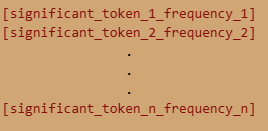

We can then pass this embedding into a single layer ANN, using a sigmoid function to classify the outputs.

We can then take the maximum probability across the outputs as the message label.

In [1]:
%%shell
jupyter nbconvert --to html "/content/Lab5_Spam_Detection.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 1053951 bytes to /content/Lab5_Spam_Detection.html
